In [7]:
from scipy import stats
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import Image

Imagine one has the following data:

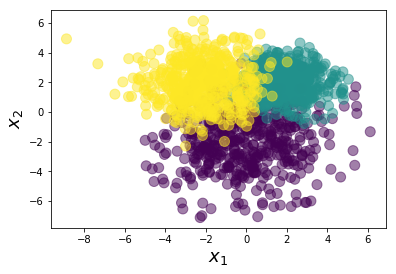

In [8]:
F = 2 # number of features
K = 3 # number of classes of output
Nclass = 500 # number of points per class
#generating input
X_a = np.random.normal(scale=2.0, size=(Nclass,F))+np.array([0,-2])
X_b = np.random.normal(scale=1.0, size=(Nclass,F))+np.array([2,2])
X_c = np.random.normal(scale=1.5, size=(Nclass,F))+np.array([-2,2])
X = np.vstack([X_a,X_b,X_c])
# generating some 3-class output                                                                                                                                                                        
t = np.array([0]*Nclass + [1]*Nclass+ [2]*Nclass)

plt.scatter(X[:,0], X[:,1], c=t, s=100, alpha=0.5)
plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18)
plt.show()

# implementing 1-hidden layer, neural net, from scratch

how to classify  new data point, ${\bf x}_{\rm new}$ ? 

**The idea** in ML for classification is to model the probability 
$$
p({\cal C_k} | {\cal D},{\bf w})
$$
of a given class ${\cal C}_k$, given some data ${\cal D}$ and the parameters of the model, ${\bf w}$. 

**The distribution function** of a categorical variable $Y$ is the _generalised Bernoulli distribution_ 

**The likelihood** of $Y$ given a dataset o size $N$ is thus:
$$
{\cal L}({\bf T}|{\bf w}) = \prod_{i=1}^N \prod_{k=1}^K p({\cal C_k} | {\bf x}_i,{\bf w})^{t_{ik}}
$$
which is equivalent to minimize:
$$
{\rm Cost}=-\ln{\cal L} = -\sum_{i=1}^N\sum_{k=1}^Kt_{ik}\ln p({\cal C_k} | {\bf x}_i,{\bf w})~.
$$

This is the so-called **cross-entropy** function.

call $p({\cal C_k} | {\bf x}_i,{\bf w})$ as $y_k({\bf x,w})$

________
Note: the output variable $t_{ik}$ should be represented in the "1-to-K" scheme (or "one-hot-encoded"); i.e. if
point $i$ belongs to class $k$, then $(t_{i1},t_{i2},...,t_{ik},...,t_{iK})=(0,0,...,1,...,0)$


A usual measure of the learning performance is the **classification rate**:

In [9]:
def classification_rate(Y, P):
    n_correct = 0
    n_total = 0
    for i in range(len(Y)):
        n_total += 1
        if Y[i] == P[i]:
            n_correct += 1
    return float(n_correct) / n_total

**DATA PREPARATION**

In [10]:
perm = np.random.permutation(len(X))
X = X[perm]
t = t[perm]
test_size = int(0.2*len(X))
x_test = X[:test_size]
x_train = X[test_size:]
t_test = t[:test_size]
t_train = t[test_size:]

# The simplest Neural Network

**Hidden layer** transformation function:
$$
z_h = f\left(\sum_{f=1}^F w_{fh}x_f + b_h\right)~~~~ \Rightarrow~~~~ {\bf Z}=f({\bf XW+B})
$$
${\bf W,B}$: parameters (weights) to be learned!

In [12]:
# randomly initialize weights
np.random.seed(342)
F=2  # number of features in data
H=5  # number of neurons in the hidden layer
W = np.random.randn(F,H)
B = np.random.randn(H)  # (in reality B is NxH matrix, but with identical row vectors; numpy will understand...)

In [13]:
print(W)

[[ 0.08814812 -0.52680247 -0.19045072  0.46183318 -1.97593416]
 [-1.07694874 -1.57609239  1.34854194 -1.24623154 -0.65846849]]


A popular **activation function** in early times (now essentially deprecated):
$$
f(x)=\frac{1}{1+e^{-x}}
$$

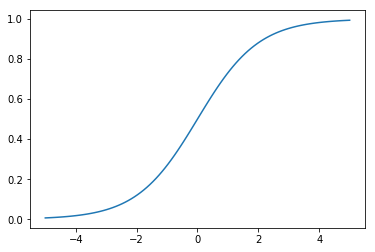

In [14]:
x_arr=np.linspace(-5,5,100)
plt.plot(x_arr,1/(1+np.exp(-x_arr)))
plt.show()

In [15]:
def Z(X,W,b):
    return 1 / (1 + np.exp(-X.dot(W)-b)) 

The **output layer** should give the probabilities for each class.
A convenient choice is the **softmax function**:
$$
p({\cal C}_k|{\cal D},{\bf w}) = y(a_k)= \frac{e^{a_k}}{\sum_{j=1}^K e^{a_j}},~~~~~ \sum_k y(a_k)=1
$$
here
$$
{\bf A}=\{a_k\}~;~~~ {\bf A} = {\bf ZV + C} 
$$
where:
${\bf V,C}$: parameters (weights) to be learned as well

In [16]:
# randomly initialize weights
K=3  # number of classes in output
V = np.random.randn(H,K)
C = np.random.randn(K)

In [17]:
def Y(X,W,b,V,c):
    A = Z(X,W,b).dot(V) + c
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True)
    return Y

## Training the Neural Network

In [18]:
# Cost function is the "cross entropy"
def cost(T,y):
    tot = T*np.log(y)
    return -tot.sum()

Model is complex; Cost function is complicated, thus optimum parameters (weights) cannot be obtained analytically 

Here we follow the method of **Backpropagation**:

For the $(i+1)$-th iteration (or epoch), we update the parameter $\alpha_{mn}$ as: 

$$
\alpha_{pq}^{i+1} = \alpha_{pq}^i - \gamma^i \sum_{n=1}^N \frac{\partial {\cal C}_n}{\partial \alpha^i_{pq}}
$$
where:
$$ \alpha_{pq} = w_{pq}, b_{pq}, v_{pq}, c_{pq} $$
$$ {\rm Cost} = \sum_{n=1}^N {\cal C}_n $$
$$ \gamma^i:~~~ {\rm learning~rate} $$

Note we have $F\times H + H + H\times K + K = 33$ parameters to fit for neural net.

Let's code the derivatives by hand:

$$
\sum_{n}\frac{\partial{\cal C}_n}{\partial w_{fh}} = \sum_n \sum_k  (t-y)_{nk} v_{hk}z_{nh}(1-z_{nh}) x_{nf} 
$$



In [19]:
def derivative_W( X, Z, T, Y, V):
    preres = (T-Y).dot(V.T) * Z * (1- Z)
    return X.T.dot(preres)

$$
\sum_{n}\frac{\partial{\cal C}_n}{\partial b_{h}} = \sum_n \sum_k  (t-y)_{nk} v_{hk}z_{nh}(1-z_{nh}) 
$$

In [20]:
def derivative_B(T, Y, V, Z):                                                                                                                                    
    return ((T-Y).dot(V.T)*Z*(1-Z)).sum(axis=0)

$$
\sum_{n}\frac{\partial{\cal C}_n}{\partial v_{hk}} = \sum_n (t-y)_{nk}z_{nh}
$$

In [21]:
def derivative_V(Z, T, Y):
    return Z.T.dot(T-Y)  

$$
\sum_{n}\frac{\partial{\cal C}_n}{\partial c_{k}} = \sum_n (t-y)_{nk}
$$

In [22]:
def derivative_C(T, Y):
    return (T-Y).sum(axis=0)

**choose learning rate:**  

In [23]:
learning_rate=1.e-4

**Putting everything together**

In [24]:
N_epochs=3000  # number of epochs (iterations for the gradient descent)

In [25]:
def fit(X,t,W,B,V,C,gamma):
    N=len(X)
    # one-hot-encoding the target
    T = np.zeros((N,K))
    for i in range(N):
        T[i, t[i]] = 1
    # updating weights
    for epoch in range(N_epochs):
        output = Y(X,W,B,V,C)
        hidden = Z(X,W,B)
        V += gamma * derivative_V(hidden, T, output)
        C += gamma * derivative_C(T, output)
        W += gamma * derivative_W(X, hidden, T, output, V)
        B += gamma * derivative_B(T, output, V, hidden)
        if epoch % 100 == 0: # every 100 epochs
            co = cost(T, output)
            P = np.argmax(output, axis=1) #prediction
            r = classification_rate(t, P)
            print('epoch:',epoch,' cost: ', co, ' classification rate: ',r)

In [26]:
fit(x_train,t_train,W,B,V,C,learning_rate)

epoch: 0  cost:  1476.386828167616  classification rate:  0.2575
epoch: 100  cost:  748.7146193224653  classification rate:  0.8375
epoch: 200  cost:  556.1035594484074  classification rate:  0.8691666666666666
epoch: 300  cost:  470.7273201610848  classification rate:  0.8841666666666667
epoch: 400  cost:  432.7165436837373  classification rate:  0.8866666666666667
epoch: 500  cost:  412.344394048538  classification rate:  0.8875
epoch: 600  cost:  399.7873055398468  classification rate:  0.8891666666666667
epoch: 700  cost:  391.3362006010504  classification rate:  0.8891666666666667
epoch: 800  cost:  385.2809989226016  classification rate:  0.8908333333333334
epoch: 900  cost:  380.7257086709364  classification rate:  0.8883333333333333
epoch: 1000  cost:  377.1598160963088  classification rate:  0.8883333333333333
epoch: 1100  cost:  374.2767085778401  classification rate:  0.8883333333333333
epoch: 1200  cost:  371.8873180275507  classification rate:  0.8883333333333333
epoch: 13

Now we see how well it can **predict new (test) data**

In [27]:
def score(X_test,t_test):
    #output_test, hidden_test = self.forward(Xtest,self.W,self.B,self.V,self.C)
    output_test = Y(X_test,W,B,V,C)
    hidden_test = Z(X_test,W,B)
    P_test = np.argmax(output_test, axis=1)
    r_test = classification_rate(t_test, P_test)
    return r_test

In [28]:
score(x_test,t_test)

0.8666666666666667

# comparing with scikit-learn's neural net

In [29]:
from sklearn.neural_network import MLPClassifier

In [30]:
clf = MLPClassifier(hidden_layer_sizes=5, activation='logistic', learning_rate_init=1.e-4,
                    max_iter=3000)

In [31]:
clf.fit(x_train, t_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=5, learning_rate='constant',
              learning_rate_init=0.0001, max_fun=15000, max_iter=3000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [32]:
clf.score(x_test, t_test)

0.88

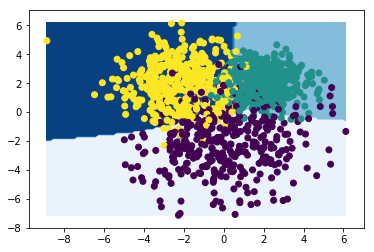

In [35]:
xx=np.linspace(np.min(X[:,0]),np.max(X[:,0]),100)
yy=np.linspace(np.min(X[:,1]),np.max(X[:,1]),100)
xx, yy = np.meshgrid(xx, yy)
Xfull = np.hstack((xx.reshape((-1,1)), yy.reshape((-1,1)) ))

Z = clf.predict(Xfull)
Z = Z.reshape(xx.shape)
plt.contourf(xx,yy,Z,cmap=plt.cm.get_cmap('Blues'))
#plt.colorbar()
plt.scatter(x_train[:,0],x_train[:,1],c=t_train)
plt.show()

In [36]:
clf.coefs_

[array([[ 0.17659821, -1.06526355,  1.25320365, -1.186394  , -0.38495702],
        [-1.47267807,  0.69133471,  0.21769553,  0.27210834, -1.18199808]]),
 array([[ 1.27325884, -1.36592518, -1.34726881],
        [-1.2208782 , -1.11664206,  0.53921845],
        [-0.57755571,  1.35005477, -1.30349889],
        [-0.82212234, -1.27554259,  0.95089559],
        [ 1.12661068, -1.45028047, -0.38053056]])]